<a href="https://colab.research.google.com/github/Pensom19/atest/blob/main/luna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mne pyxdf

In [ ]:
# Import necessary libraries
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import mne
from google.colab import files
import io
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt

In [ ]:
# ขั้นแรก: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# เลือกไฟล์ XDF จาก Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'  # แก้ไขที่อยู่ไฟล์ให้ถูกต้อง

# ฟังก์ชันในการโหลดข้อมูลจากไฟล์ XDF
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# เรียกใช้งานฟังก์ชัน
df, sampling_rate, markers = load_data(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# โหลดข้อมูลจากไฟล์ XDF
streams, header = pyxdf.load_xdf('/content/drive/MyDrive/Colab Notebooks/eeg.xdf')

# สมมติว่า eeg_stream และ marker_stream เป็นชื่อของ streams ที่กำลังถูกใช้
eeg_stream = [s for s in streams if s['info']['name'][0] == 'eeg'][0]
marker_stream = [s for s in streams if s['info']['name'][0] == 'PsychoPyMarkers'][0]

# ดึงข้อมูลสัญญาณ EEG และ marker
eeg_data = eeg_stream['time_series']
markers = marker_stream['time_series']

# กำหนด start และ end marker สำหรับ SSVEP
ssvep_5hz_trigger_start = 2  # Trigger เริ่มต้นสำหรับ SSVEP 5 Hz
ssvep_5hz_trigger_end = 12   # Trigger สิ้นสุดสำหรับ SSVEP 5 Hz
ssvep_7hz_trigger_start = 4  # Trigger เริ่มต้นสำหรับ SSVEP 7 Hz
ssvep_7hz_trigger_end = 14   # Trigger สิ้นสุดสำหรับ SSVEP 7 Hz

# ฟังก์ชันสำหรับตัดช่วงของสัญญาณ
def cut_ssvep_signal(eeg_data, markers, start_trigger, end_trigger, pre_time=1, post_time=2, fs=256):
    segments = []
    for i in range(len(markers) - 1):
        if markers[i][0] == start_trigger and markers[i + 1][0] == end_trigger:
            start = int((markers[i][0] - pre_time) * fs)
            end = int((markers[i + 1][0] + post_time) * fs)
            segment = eeg_data[start:end]  # ตรวจสอบให้แน่ใจว่า segment มีขนาด (n_samples, n_channels)
            segments.append(segment)
    return np.array(segments)  # แปลงเป็น array 3 มิติ (n_epochs, n_samples, n_channels)

# ตัดช่วงสัญญาณ EEG สำหรับ SSVEP 5 Hz และ 7 Hz
eeg_segments_5hz = cut_ssvep_signal(eeg_data, markers, ssvep_5hz_trigger_start, ssvep_5hz_trigger_end)
eeg_segments_7hz = cut_ssvep_signal(eeg_data, markers, ssvep_7hz_trigger_start, ssvep_7hz_trigger_end)

# ตรวจสอบขนาดของ segments
print(f'ขนาดของ 5 Hz segments: {eeg_segments_5hz.shape}')
print(f'ขนาดของ 7 Hz segments: {eeg_segments_7hz.shape}')

# สร้างโครงสร้างข้อมูล MNE
n_channels = eeg_data.shape[1]  # จำนวนช่องสัญญาณจาก stream หลัก
info = mne.create_info(ch_names=[f'EEG_{i+1}' for i in range(n_channels)], sfreq=256, ch_types='eeg')

# สร้าง MNE EpochsArray
epochs_5hz = mne.EpochsArray(eeg_segments_5hz.transpose(0, 2, 1), info)  # ขนาด: (n_epochs, n_samples, n_channels)
epochs_7hz = mne.EpochsArray(eeg_segments_7hz.transpose(0, 2, 1), info)

# ฟังก์ชันสำหรับบันทึกข้อมูลเป็นไฟล์ XDF
def write_xdf(filename, epochs_list, markers):
    # สร้าง root element
    root = ET.Element('XDF')

    for i, epochs in enumerate(epochs_list):
        data = epochs.get_data()  # ดึงข้อมูล (ขนาด: n_epochs, n_channels, n_samples)
        timestamps = np.arange(data.shape[1]) / epochs.info['sfreq']  # สร้าง timestamps

        # สร้าง stream element
        stream = ET.SubElement(root, 'Stream')

        # เพิ่มข้อมูลของ stream
        info = ET.SubElement(stream, 'Info')
        name = ET.SubElement(info, 'Name')
        name.text = f'eeg_{i + 1}'

        type_ = ET.SubElement(info, 'Type')
        type_.text = 'EEG'

        # เพิ่มข้อมูลของ channels
        channels = ET.SubElement(info, 'Channels')
        for ch in epochs.info['ch_names']:
            channel = ET.SubElement(channels, 'Channel')
            channel.text = ch

        sample_rate = ET.SubElement(info, 'SampleRate')
        sample_rate.text = str(int(epochs.info['sfreq']))

        # เพิ่มข้อมูล timestamps
        time_series = ET.SubElement(stream, 'TimeSeries')
        for ts in timestamps:
            timestamp_elem = ET.SubElement(time_series, 'Timestamp')
            timestamp_elem.text = str(ts)

        # เพิ่มข้อมูล data
        data_elem = ET.SubElement(stream, 'Data')
        for epoch in data:  # ลูปผ่านแต่ละ epoch
            for channel_data in epoch:  # ลูปผ่านแต่ละ channel
                data_point = ET.SubElement(data_elem, 'DataPoint')
                data_point.text = ','.join(map(str, channel_data))

    # บันทึก markers ใน stream แยก
    markers_stream = ET.SubElement(root, 'Stream')
    markers_info = ET.SubElement(markers_stream, 'Info')
    markers_name = ET.SubElement(markers_info, 'Name')
    markers_name.text = 'Markers'
    markers_type = ET.SubElement(markers_info, 'Type')
    markers_type.text = 'Markers'

    # เพิ่มข้อมูลของ markers
    markers_data_elem = ET.SubElement(markers_stream, 'Data')
    for marker in markers:  # ลูปผ่านแต่ละ marker
        marker_elem = ET.SubElement(markers_data_elem, 'Marker')
        marker_elem.text = str(marker[0])

    # สร้างต้นไม้และบันทึกลงไฟล์
    tree = ET.ElementTree(root)
    tree.write(filename, encoding='utf-8', xml_declaration=True)

# เรียกใช้ฟังก์ชันสำหรับบันทึกข้อมูล
write_xdf('/content/drive/MyDrive/Colab Notebooks/neweeg.xdf', [epochs_5hz, epochs_7hz], markers)


ขนาดของ 5 Hz segments: (1, 3328, 24)
ขนาดของ 7 Hz segments: (1, 3328, 24)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File 1:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1


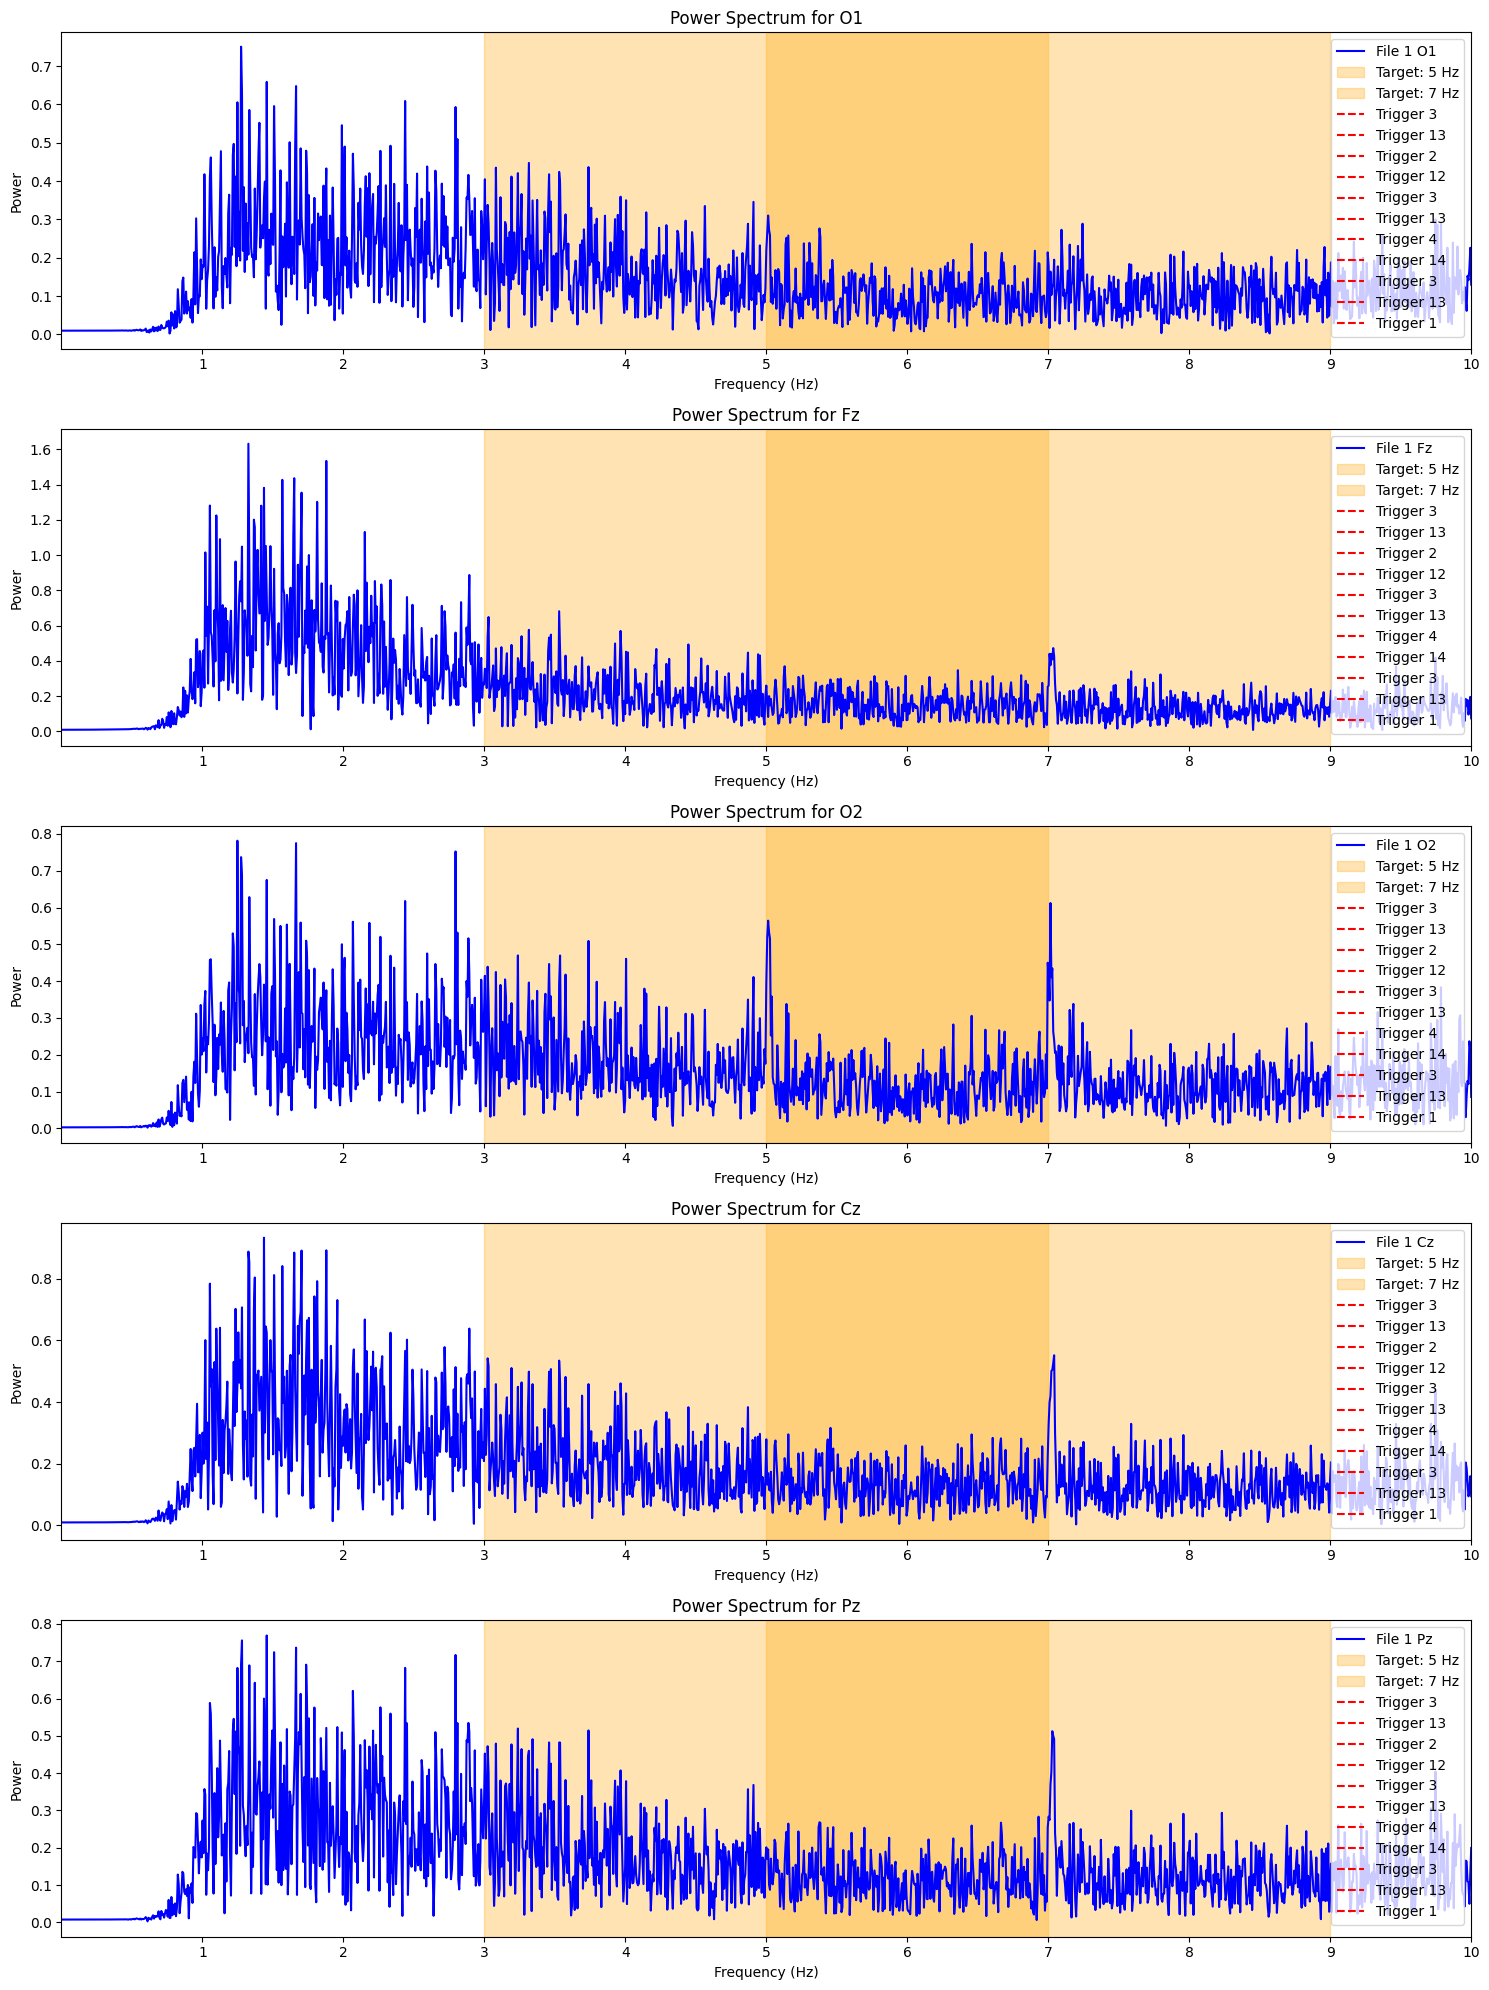

In [ ]:
# นำเข้าลิไบรารีที่จำเป็น
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive
import pyxdf
import os

# เมานต์ Google Drive
drive.mount('/content/drive')

# ฟังก์ชันเพื่อโหลดข้อมูลจากไฟล์ .xdf
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # ค้นหาสตรีมที่เกี่ยวกับ EEG และ Marker
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    # ถ้าไม่พบสตรีม EEG ให้แสดงข้อความข้อผิดพลาด
    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    # ดึงข้อมูล EEG
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # ดึง Marker หากมี
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# ฟังก์ชันสำหรับสร้าง Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# ฟังก์ชันเพื่อกรองสัญญาณด้วย Bandpass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# ฟังก์ชันเพื่อพล็อต Power Spectrum พร้อม FFT และหลายความถี่เป้าหมาย
def plot_power_spectrum_fft(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    # วนลูปผ่านแต่ละช่องสัญญาณ
    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # กรองสัญญาณด้วย Bandpass Filter (ตัวอย่างที่ช่วง 1-50 Hz)
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT ของสัญญาณที่ถูกกรอง
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # พล็อต Power Spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.xlim(0, 10)  # กำหนดช่วงความถี่ที่ 0-10 Hz
            plt.xticks(np.arange(1, 11, 1))  # ตั้งค่า tick สำหรับความถี่ตั้งแต่ 1 ถึง 10 Hz

            # เน้นความถี่เป้าหมาย
            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz')

            # ทำเครื่องหมายทริกเกอร์ด้วยเส้นแนวตั้ง
            if markers:  # ตรวจสอบว่ามี markers หรือไม่
                for timestamp, marker in markers:
                    plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')
                    # เพื่อไม่ให้มี label ซ้ำในเส้นแนวตั้ง
                    plt.legend(loc='upper right')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# โหลดไฟล์ .xdf จาก Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'

# โหลดข้อมูลจากไฟล์ .xdf
df1, sampling_rate1, markers1 = load_data(file_path)

# แสดง Marker เพื่อตรวจสอบ
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# เลือกช่องสัญญาณที่ต้องการพล็อต
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# พล็อต Power Spectrum พร้อมความถี่เป้าหมายที่ 5 และ 7 Hz
plot_power_spectrum_fft(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freqs=[5, 7], bandwidth=2)

# แสดงกราฟ
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1


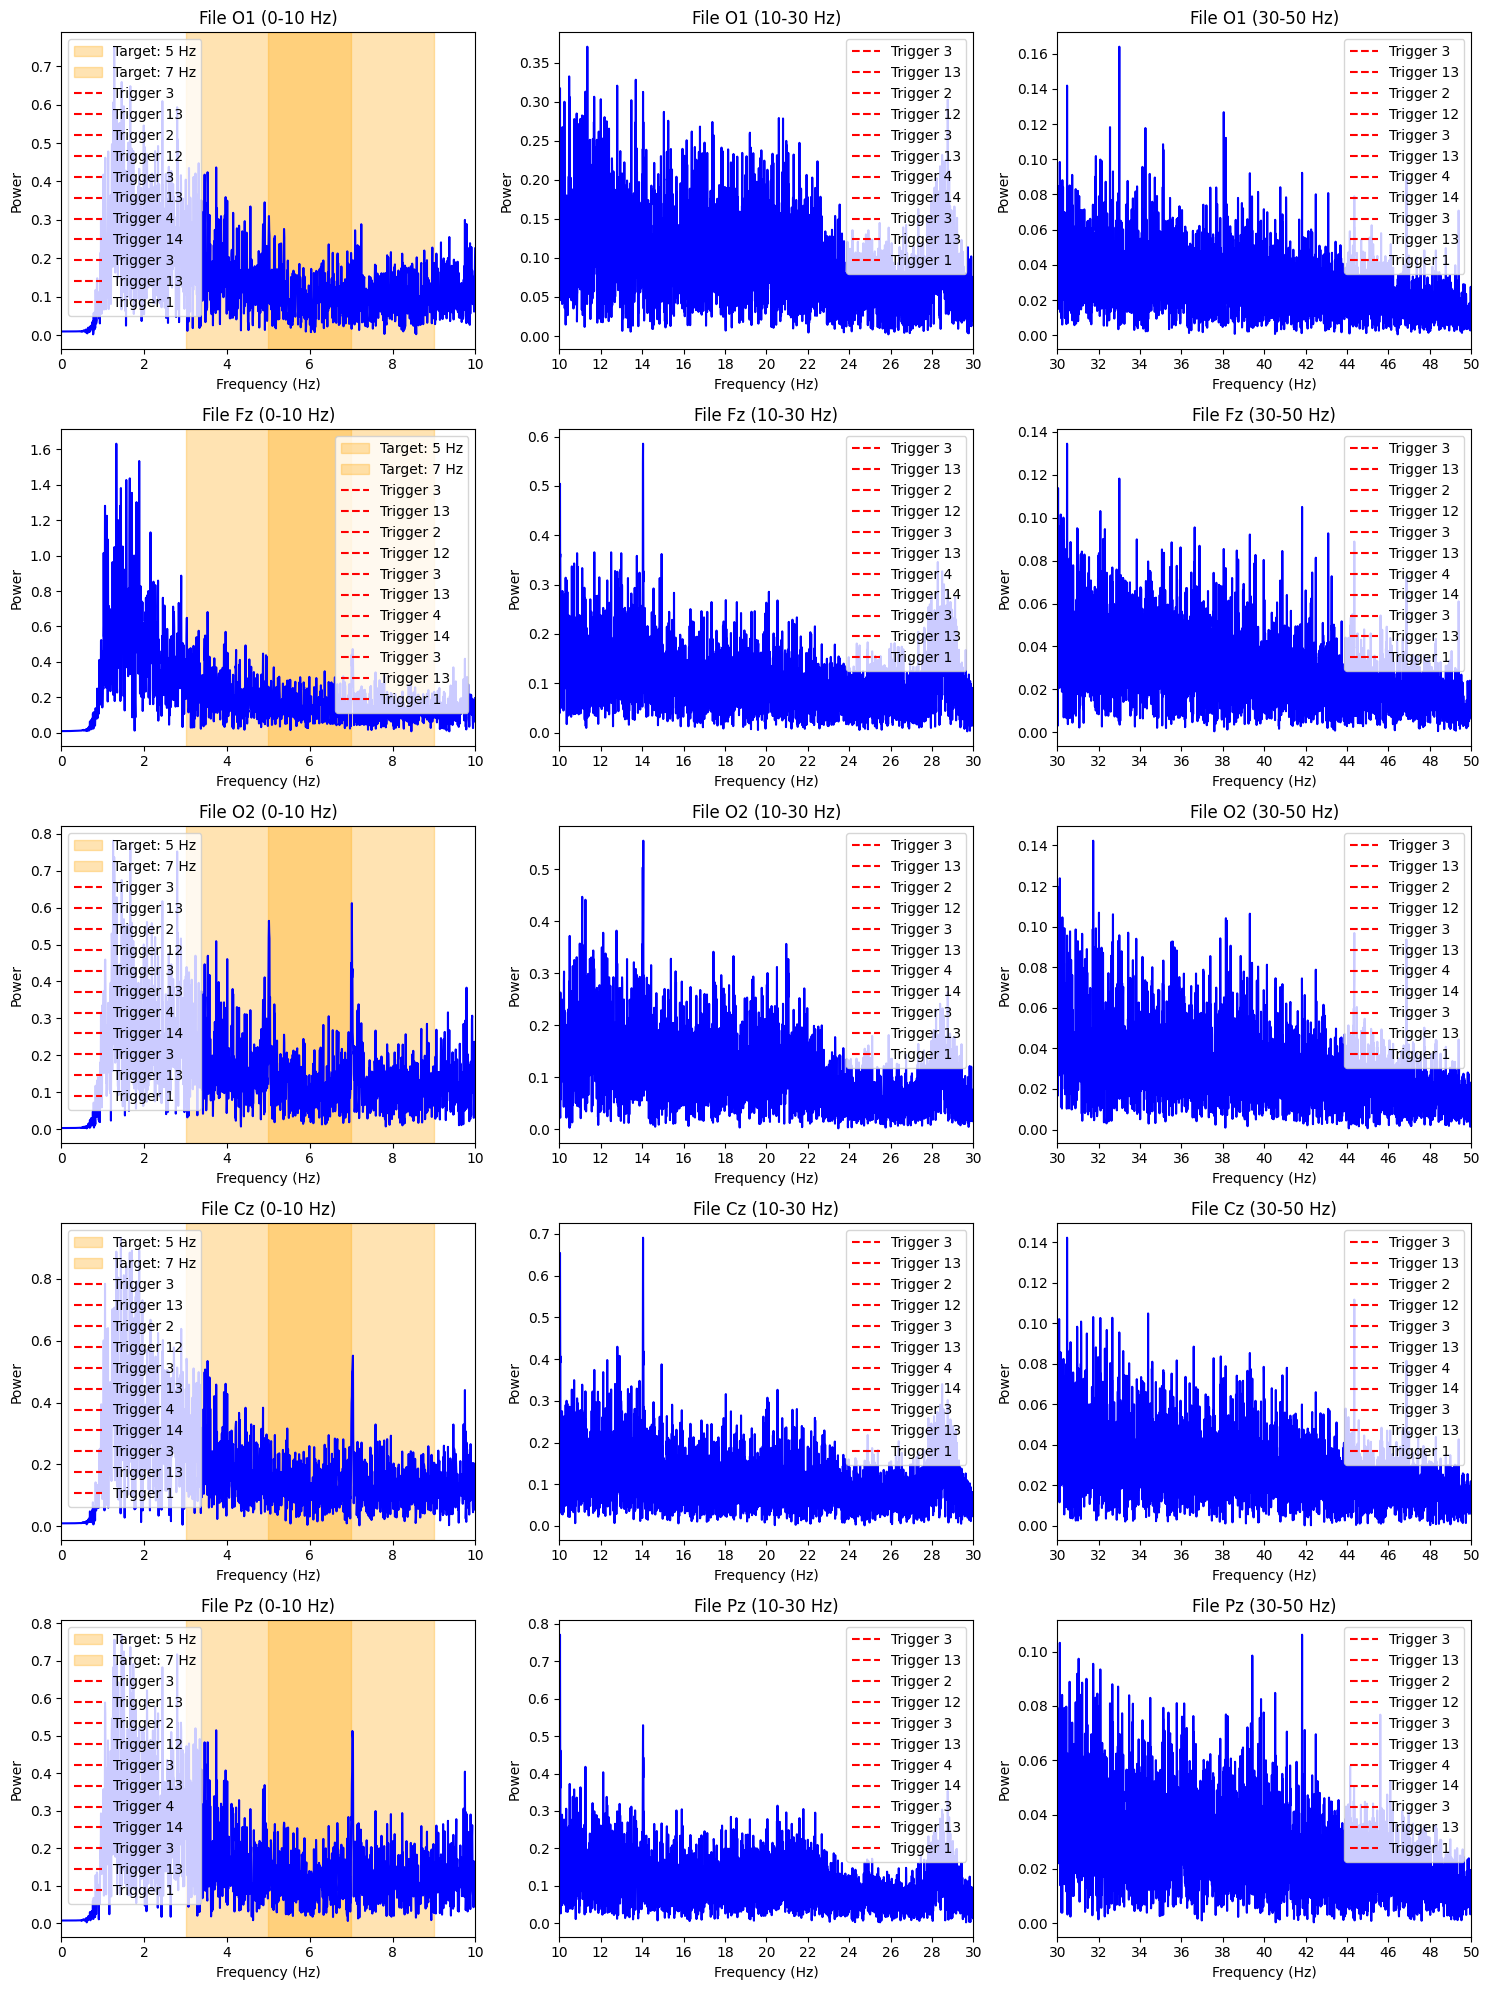

In [ ]:
# Install necessary libraries
!pip install pyxdf
!pip install mne

# Import necessary libraries
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import mne
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define file path for the XDF file
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'  # Adjust the file path as necessary

# Function to load data from an XDF file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # Locate the EEG and Marker streams
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"No stream named 'eeg' found in file {filepath}")

    # Extract EEG data
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # Extract markers if available
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function to create a Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to filter signal with Bandpass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to plot Power Spectrum with FFT and target frequencies in segmented ranges
def plot_power_spectrum_segmented(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    # Define frequency ranges for segmentation
    freq_ranges = [
        (0, 10),   # Low frequencies
        (10, 30),  # Mid frequencies
        (30, 50)   # High frequencies
    ]

    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Filter signal with Bandpass Filter (1-50 Hz)
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Create subplots for each frequency range
            for j, (low_freq, high_freq) in enumerate(freq_ranges):
                plt.subplot(len(channels), len(freq_ranges), i * len(freq_ranges) + j + 1)
                mask = (xf >= low_freq) & (xf < high_freq)  # Frequency mask
                plt.plot(xf[mask], power_spectrum[mask], color=color)
                plt.title(f'{title_prefix} {channel} ({low_freq}-{high_freq} Hz)')
                plt.xlabel('Frequency (Hz)')
                plt.ylabel('Power')
                plt.xlim(low_freq, high_freq)  # Set frequency range
                plt.xticks(np.arange(low_freq, high_freq + 1, 2))  # Adjust ticks

                # Highlight target frequencies
                for target_freq in target_freqs:
                    if low_freq <= target_freq <= high_freq:
                        plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz')

                # Mark triggers with vertical lines
                if markers:  # Check if markers exist
                    for timestamp, marker in markers:
                        plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')
                        plt.legend(loc='upper right')

                plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load data from XDF file
df, sampling_rate, markers = load_data(file_path)

# Show markers for verification
print("Markers from File:")
for timestamp, marker in markers:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# Plot Power Spectrum with segmented frequency ranges
plot_power_spectrum_segmented(df, sampling_rate, markers, channels, 'File', color='blue', target_freqs=[5, 7], bandwidth=2)

# Show the plot
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1


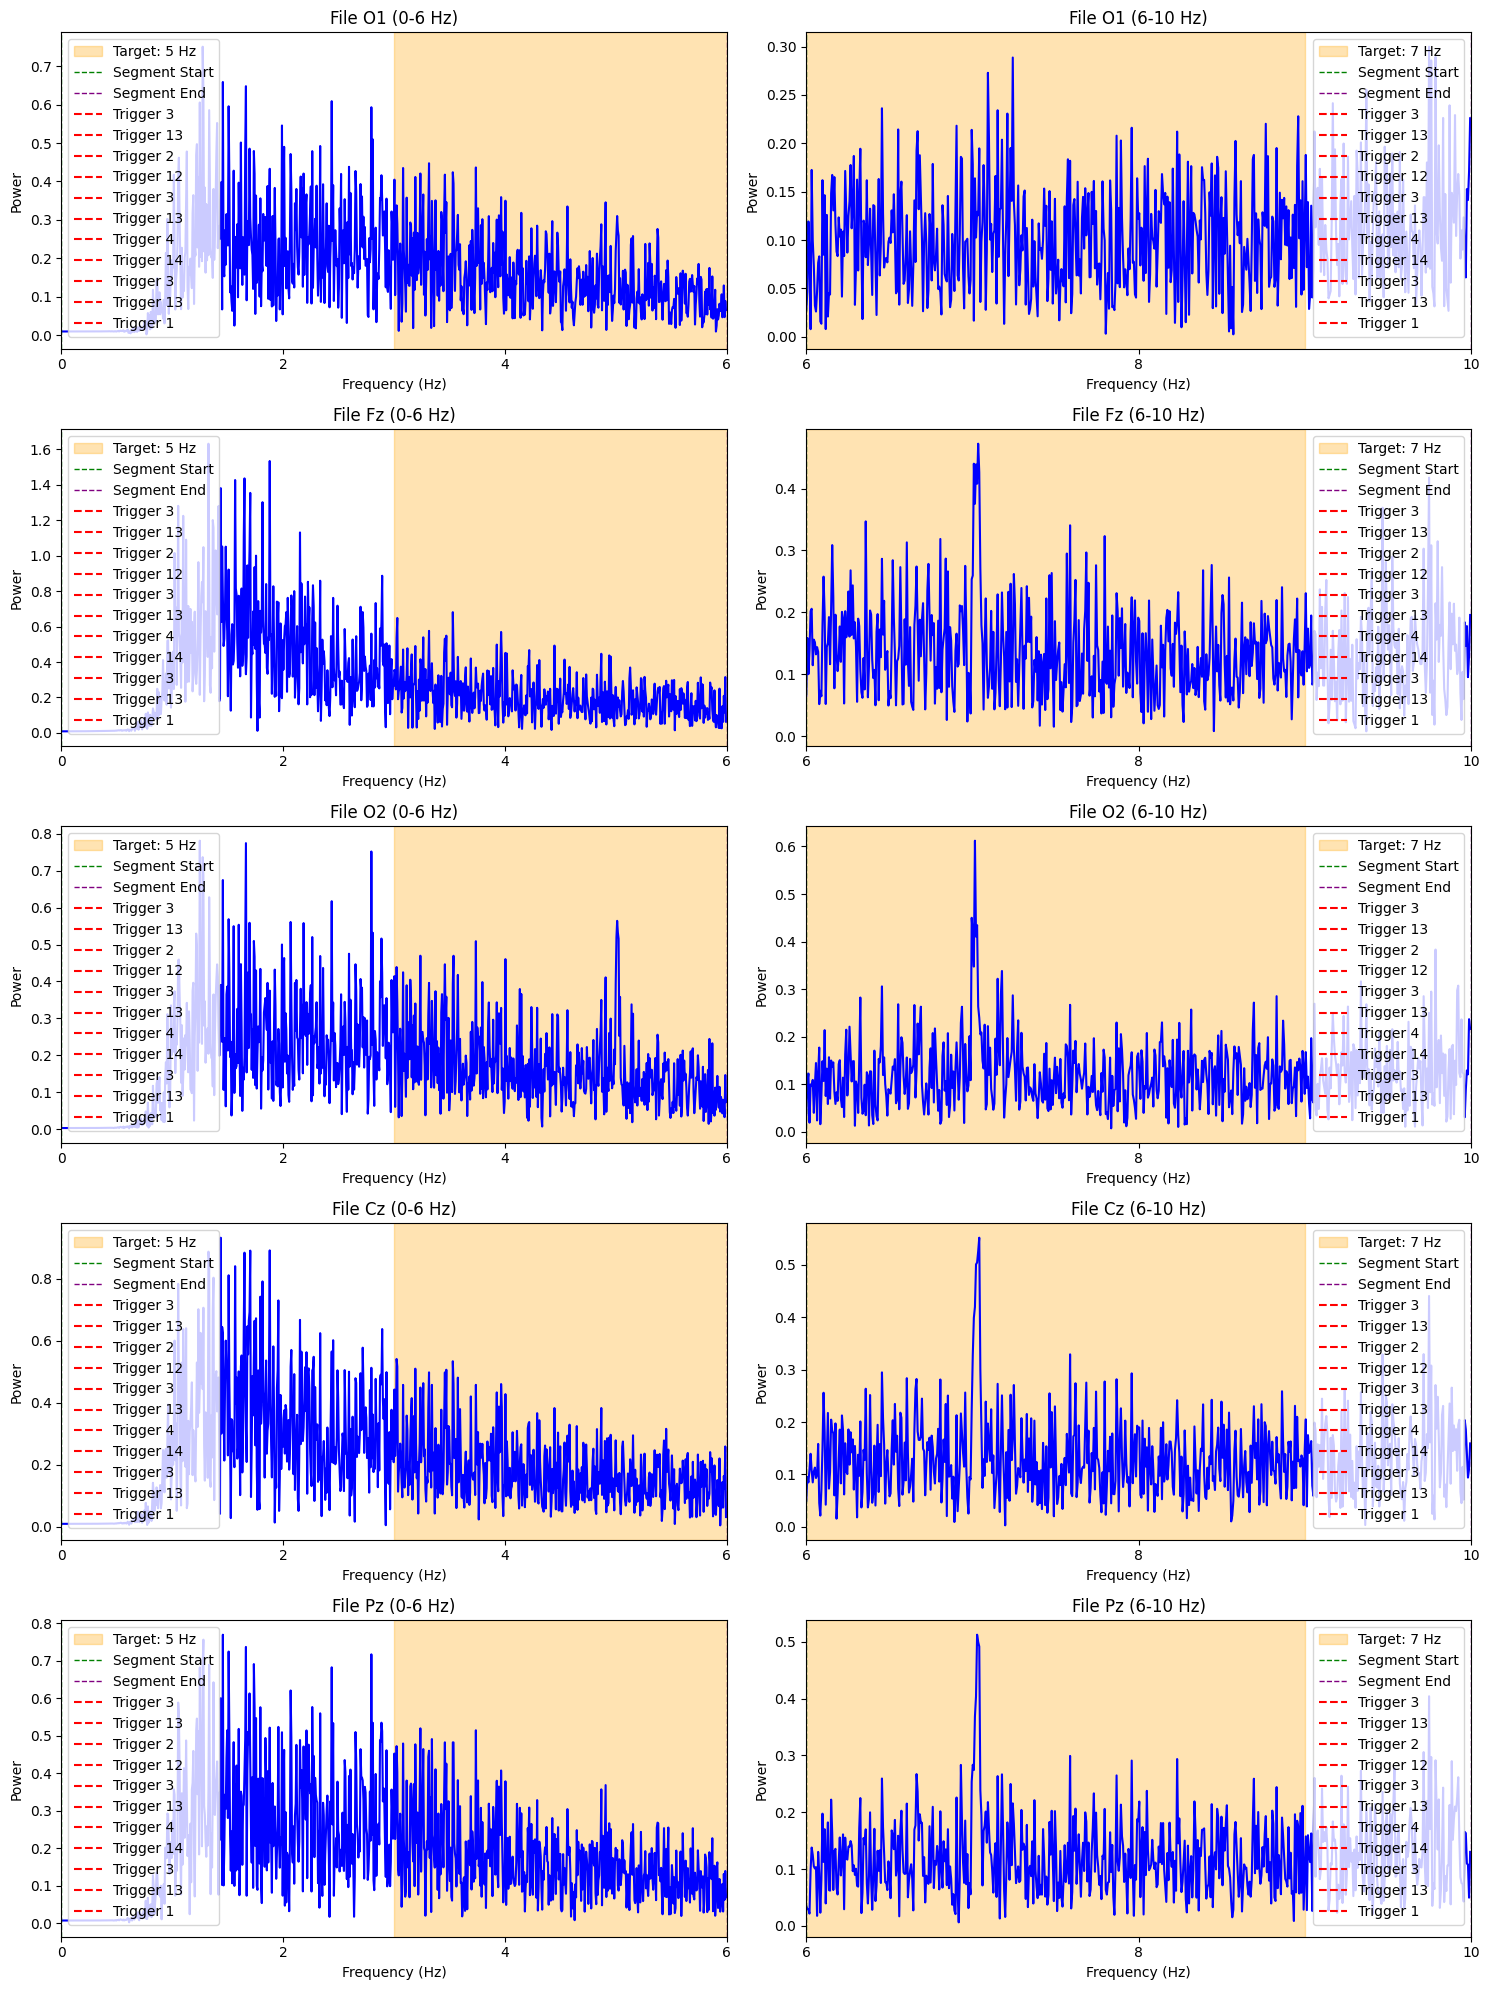

In [ ]:
# Install necessary libraries
#!pip install pyxdf
#!pip install mne

# Import necessary libraries
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import mne
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define file path for the XDF file
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'  # Adjust the file path as necessary

# Function to load data from an XDF file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # Locate the EEG and Marker streams
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"No stream named 'eeg' found in file {filepath}")

    # Extract EEG data
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # Extract markers if available
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function to create a Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to filter signal with Bandpass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to plot Power Spectrum with FFT and target frequencies in segmented ranges with markers
def plot_power_spectrum_segmented_with_markers(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    # Define frequency ranges for segmentation
    freq_ranges = [
        (0, 6),   # Low frequencies
        #(3, 5),  # Mid frequencies
        (6, 10)   # High frequencies
    ]

    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Filter signal with Bandpass Filter (1-50 Hz)
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Create subplots for each frequency range
            for j, (low_freq, high_freq) in enumerate(freq_ranges):
                plt.subplot(len(channels), len(freq_ranges), i * len(freq_ranges) + j + 1)
                mask = (xf >= low_freq) & (xf < high_freq)  # Frequency mask
                plt.plot(xf[mask], power_spectrum[mask], color=color)
                plt.title(f'{title_prefix} {channel} ({low_freq}-{high_freq} Hz)')
                plt.xlabel('Frequency (Hz)')
                plt.ylabel('Power')
                plt.xlim(low_freq, high_freq)  # Set frequency range
                plt.xticks(np.arange(low_freq, high_freq + 1, 2))  # Adjust ticks

                # Highlight target frequencies
                for target_freq in target_freqs:
                    if low_freq <= target_freq <= high_freq:
                        plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz')

                # Add markers for segment intervals
                plt.axvline(x=low_freq, color='green', linestyle='--', linewidth=1, label='Segment Start')
                plt.axvline(x=high_freq, color='purple', linestyle='--', linewidth=1, label='Segment End')

                # Mark triggers with vertical lines
                if markers:  # Check if markers exist
                    for timestamp, marker in markers:
                        plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')
                        plt.legend(loc='upper right')

                plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load data from XDF file
df, sampling_rate, markers = load_data(file_path)

# Show markers for verification
print("Markers from File:")
for timestamp, marker in markers:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# Plot Power Spectrum with segmented frequency ranges and segment markers
plot_power_spectrum_segmented_with_markers(df, sampling_rate, markers, channels, 'File', color='blue', target_freqs=[5, 7], bandwidth=2)

# Show the plot
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1


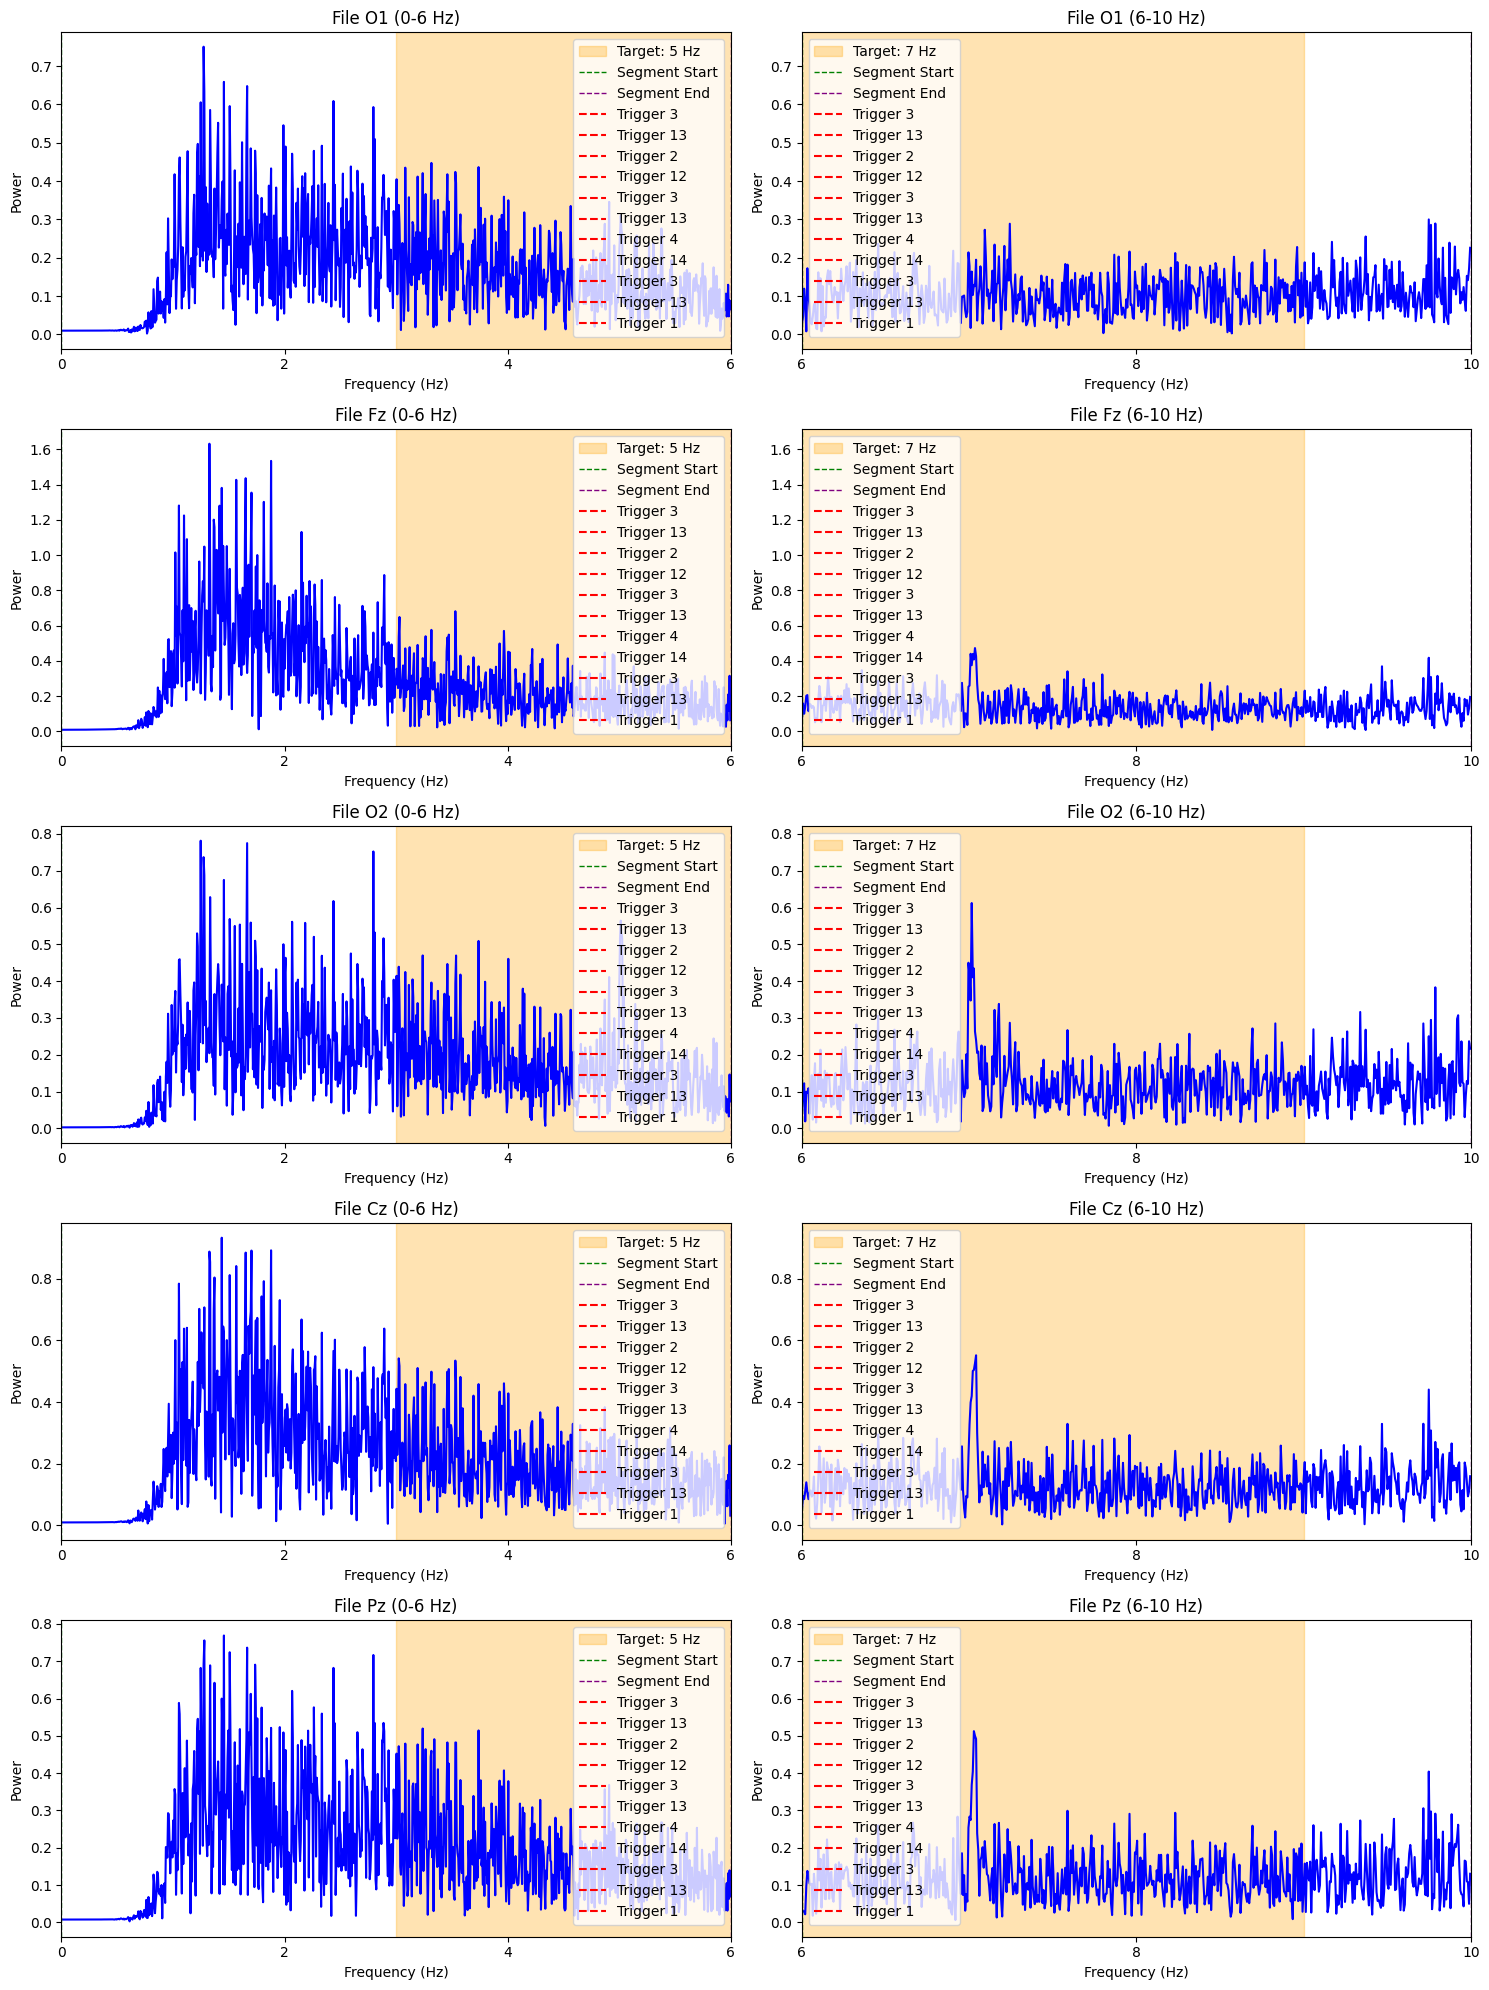

In [ ]:
# Install necessary libraries
#!pip install pyxdf
#!pip install mne

# Import necessary libraries
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import mne
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define file path for the XDF file
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'  # Adjust the file path as necessary

# Function to load data from an XDF file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # Locate the EEG and Marker streams
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"No stream named 'eeg' found in file {filepath}")

    # Extract EEG data
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # Extract markers if available
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function to create a Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to filter signal with Bandpass Filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to plot Power Spectrum with FFT and target frequencies in segmented ranges with markers
def plot_power_spectrum_segmented_with_markers(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    # Define frequency ranges for segmentation
    freq_ranges = [
        (0, 6),   # Low frequencies
        (6, 10)   # High frequencies
    ]

    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Filter signal with Bandpass Filter (1-50 Hz)
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Create subplots for each frequency range
            for j, (low_freq, high_freq) in enumerate(freq_ranges):
                plt.subplot(len(channels), len(freq_ranges), i * len(freq_ranges) + j + 1)
                mask = (xf >= low_freq) & (xf < high_freq)  # Frequency mask
                plt.plot(xf[mask], power_spectrum[mask], color=color)
                plt.title(f'{title_prefix} {channel} ({low_freq}-{high_freq} Hz)')
                plt.xlabel('Frequency (Hz)')
                plt.ylabel('Power')
                plt.xlim(low_freq, high_freq)  # Set frequency range
                plt.xticks(np.arange(low_freq, high_freq + 1, 2))  # Adjust ticks

                # Highlight target frequencies
                for target_freq in target_freqs:
                    if low_freq <= target_freq <= high_freq:
                        plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz')

                # Add markers for segment intervals
                plt.axvline(x=low_freq, color='green', linestyle='--', linewidth=1, label='Segment Start')
                plt.axvline(x=high_freq, color='purple', linestyle='--', linewidth=1, label='Segment End')

                # Mark triggers with vertical lines
                if markers:  # Check if markers exist
                    for timestamp, marker in markers:
                        # Create vertical lines for each marker
                        plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')
                        plt.fill_betweenx([0, max(power_spectrum)], timestamp - 0.5, timestamp + 0.5, color='red', alpha=0.1)  # Shade trigger area
                        plt.legend(loc='upper right')

                plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load data from XDF file
df, sampling_rate, markers = load_data(file_path)

# Show markers for verification
print("Markers from File:")
for timestamp, marker in markers:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# Plot Power Spectrum with segmented frequency ranges and segment markers
plot_power_spectrum_segmented_with_markers(df, sampling_rate, markers, channels, 'File', color='blue', target_freqs=[5, 7], bandwidth=2)

# Show the plot
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers: [(14329.452032527886, array([3], dtype=int32)), (14359.455491683912, array([13], dtype=int32)), (14359.45556908357, array([2], dtype=int32)), (14389.463451623451, array([12], dtype=int32)), (14389.463530223118, array([3], dtype=int32)), (14419.465005586622, array([13], dtype=int32)), (14419.46510648611, array([4], dtype=int32)), (14449.472949326038, array([14], dtype=int32)), (14449.47302762582, array([3], dtype=int32)), (14479.48274535872, array([13], dtype=int32)), (14479.482921557967, array([1], dtype=int32))]
Creating RawArray with float64 data, n_channels=24, n_times=39372
    Range : 0 ... 39371 =      0.000 ...   153.793 secs
Ready.


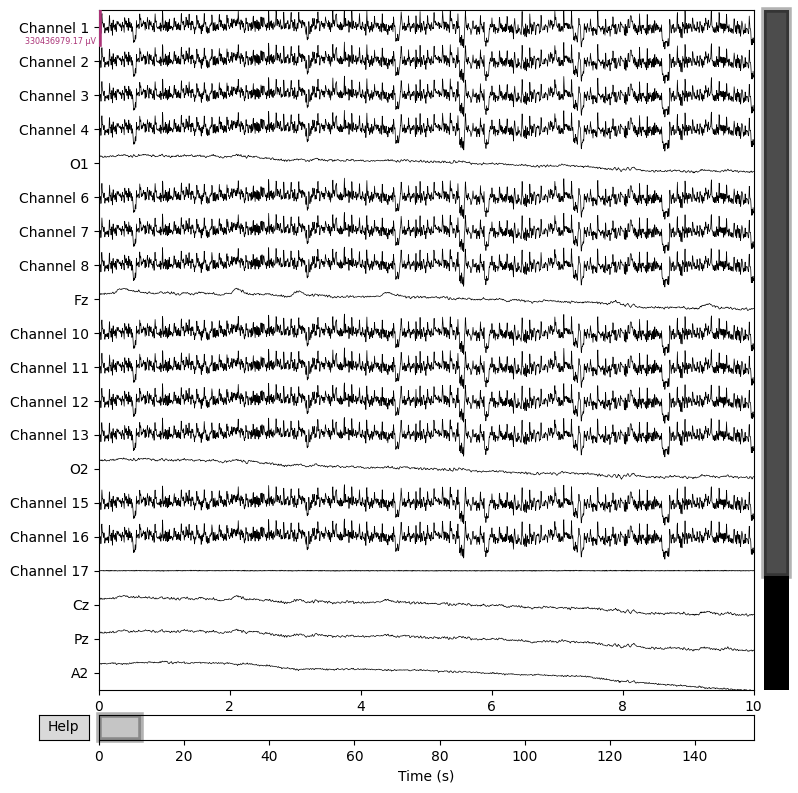

Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 129 original time points ...
6 bad epochs dropped


<ipython-input-9-bbe6202665a9>:88: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(raw, events, event_id=None, tmin=0, tmax=epoch_duration,


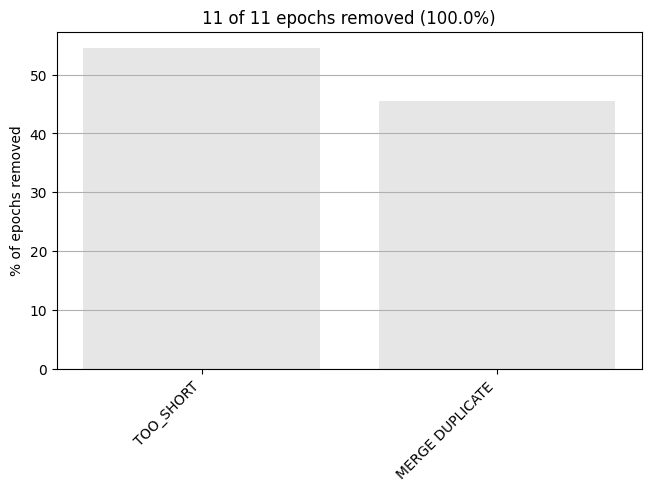

Number of epochs created: 0
Channels in epochs: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'O1', 'Channel 6', 'Channel 7', 'Channel 8', 'Fz', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'O2', 'Channel 15', 'Channel 16', 'Channel 17', 'Cz', 'Pz', 'A2', 'Channel 21', 'Channel 22', 'Channel 23', 'Channel 24']
(('TOO_SHORT',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',))


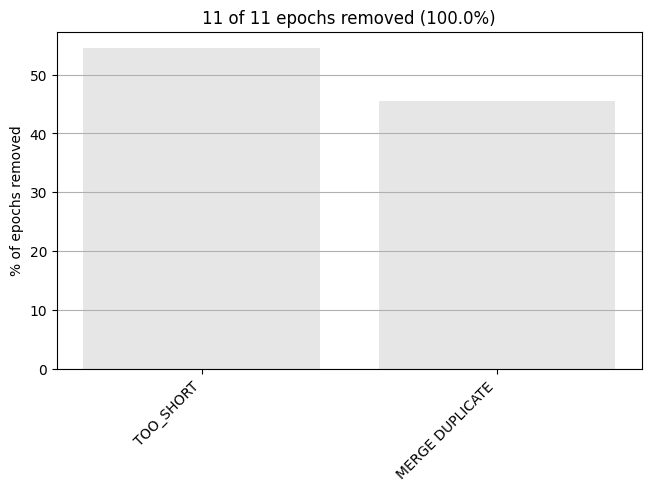

No epochs available for plotting.


In [ ]:
# Install necessary libraries
#!pip install pyxdf
#!pip install mne

# Import necessary libraries
import numpy as np
import pandas as pd
import mne
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define file path for the XDF file
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'  # Adjust the file path as necessary

# Function to load data from an XDF file (unchanged)
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # Locate the EEG and Marker streams
    for stream in streams:
        if stream['info']['name'][0].lower() == 'eeg' and stream['info']['type'][0].lower() == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0].lower() == 'markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"No stream named 'eeg' found in file {filepath}")

    # Extract EEG data
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # Extract markers if available
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function to create epochs (with additional debugging)
def create_epochs(data, markers, sampling_rate, epoch_duration=1):
    events = []
    seen_timestamps = set()  # Set to track timestamps we've already seen

    # Debugging: print marker data to ensure it is correct
    print(f"Markers: {markers}")

    for timestamp, marker in markers:
        if timestamp not in seen_timestamps:  # Only process the first occurrence of a timestamp
            try:
                event_value = int(marker[0])  # Check if marker can be converted to integer
                events.append([int(timestamp * sampling_rate), 0, event_value])
                seen_timestamps.add(timestamp)  # Mark this timestamp as seen
            except ValueError as e:
                print(f"Error converting marker {marker} at timestamp {timestamp}: {e}")

    events = np.array(events)

    if len(events) == 0:
        raise ValueError("No valid events were created from markers.")

    # Create MNE Raw object
    info = mne.create_info(ch_names=data.columns.tolist(), sfreq=sampling_rate, ch_types='eeg')
    raw = mne.io.RawArray(data.T, info)

    # Optional: Visualize the raw data before epoching
    raw.plot(scalings='auto', title='Raw EEG Data')

    # Modify reject criteria or disable it
    reject_criteria = None  # Disable rejection for testing

    try:
        epochs = mne.Epochs(raw, events, event_id=None, tmin=0, tmax=epoch_duration,
                            baseline=None, detrend=None, reject_by_annotation=False,
                            event_repeated='merge', preload=True, reject=reject_criteria, flat=None)

        # Visualize drop log to inspect rejected epochs
        epochs.plot_drop_log()

        # Check if there are epochs left after rejection
        if len(epochs) == 0:
            print("Warning: No epochs remaining after rejection.")

    except ValueError as e:
        print(f"Error creating epochs: {e}")
        return None

    return epochs

# Function to plot Power Spectrum (with additional method for psd computation)
def plot_power_spectrum(epochs, channel_names, title='Power Spectrum'):
    # Use the Welch method for power spectral density computation
    psds, freqs = epochs.compute_psd(method='welch', fmin=0.1, fmax=40).get_data(return_freqs=True)

    # Plot power spectrum for each channel
    plt.figure(figsize=(10, 6))
    for i, chan in enumerate(channel_names):
        plt.plot(freqs, psds[i], label=chan)

    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.legend()
    plt.show()

# Load data from XDF file
df, sampling_rate, markers = load_data(file_path)

# Create epochs with adjusted error handling
epochs = create_epochs(df, markers, sampling_rate, epoch_duration=0.5)

if epochs is None:
    print("Error: Epochs creation failed.")
else:
    print(f"Number of epochs created: {len(epochs)}")
    print(f"Channels in epochs: {epochs.ch_names}")

    # Check drop log
    if epochs is not None:
        print(epochs.drop_log)
        epochs.plot_drop_log()
        # ตรวจสอบจำนวน epochs ก่อนเรียกใช้ฟังก์ชัน plot_power_spectrum
if epochs is None or len(epochs) == 0:
    print("No epochs available for plotting.")
else:
    print(f"Number of epochs available: {len(epochs)}")
    print(f"Channel names: {epochs.ch_names}")

    # Plot Power Spectrum
    plot_power_spectrum(epochs, epochs.ch_names, 'EEG Power Spectrum')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers: [(14329.452032527886, array([3], dtype=int32)), (14359.455491683912, array([13], dtype=int32)), (14359.45556908357, array([2], dtype=int32)), (14389.463451623451, array([12], dtype=int32)), (14389.463530223118, array([3], dtype=int32)), (14419.465005586622, array([13], dtype=int32)), (14419.46510648611, array([4], dtype=int32)), (14449.472949326038, array([14], dtype=int32)), (14449.47302762582, array([3], dtype=int32)), (14479.48274535872, array([13], dtype=int32)), (14479.482921557967, array([1], dtype=int32))]
Creating RawArray with float64 data, n_channels=24, n_times=39372
    Range : 0 ... 39371 =      0.000 ...   153.793 secs
Ready.


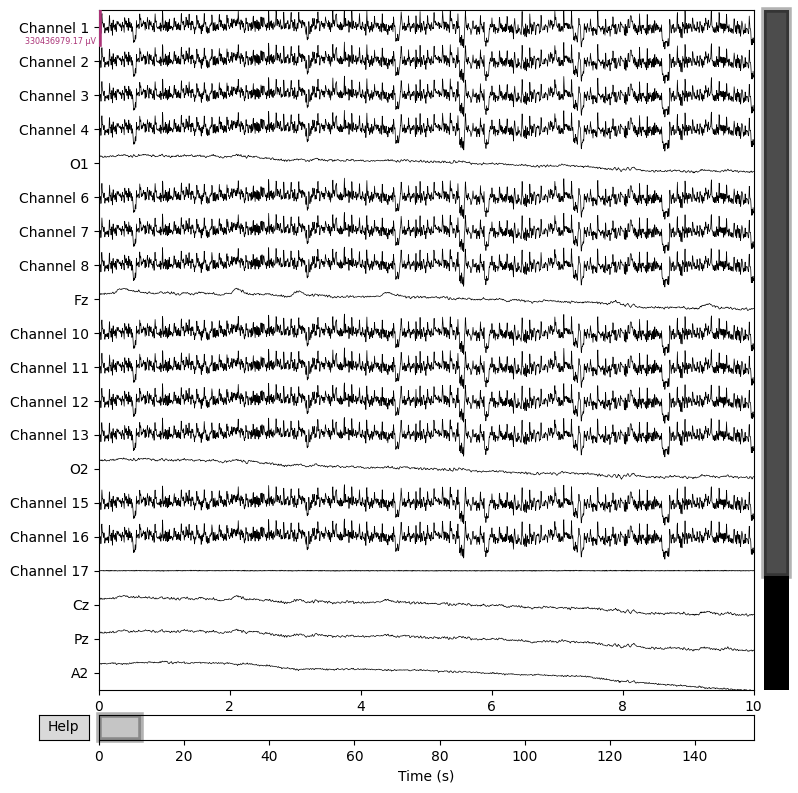

Using rejection criteria: None
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 129 original time points ...
6 bad epochs dropped


<ipython-input-24-4ce40f2aa756>:85: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(


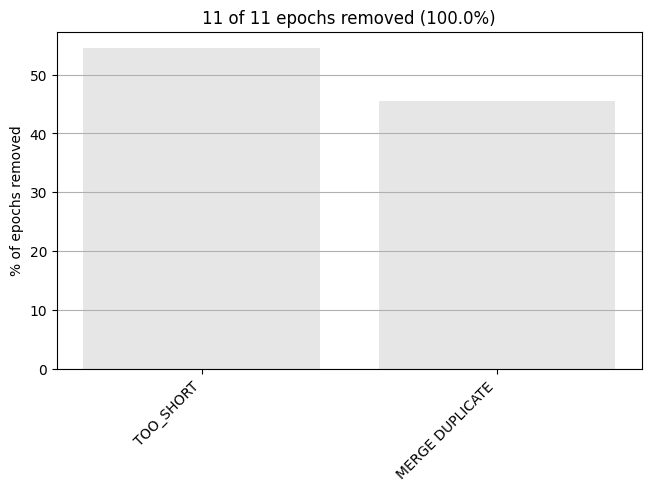

จำนวน epochs ที่สร้างขึ้น: 0
ช่องใน epochs: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'O1', 'Channel 6', 'Channel 7', 'Channel 8', 'Fz', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'O2', 'Channel 15', 'Channel 16', 'Channel 17', 'Cz', 'Pz', 'A2', 'Channel 21', 'Channel 22', 'Channel 23', 'Channel 24']
(('TOO_SHORT',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',))


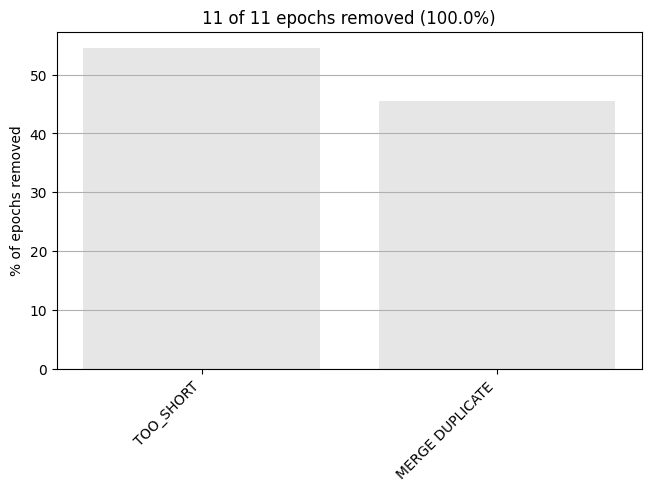

ไม่มี epochs สำหรับการ plot


In [ ]:
# ติดตั้งไลบรารีที่จำเป็น
#!pip install pyxdf
#!pip install mne

# นำเข้าไลบรารีที่จำเป็น
import numpy as np
import pandas as pd
import mne
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive

# ขั้นตอนที่ 1: เชื่อมต่อ Google Drive
drive.mount('/content/drive')

# กำหนดเส้นทางไฟล์สำหรับไฟล์ XDF
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg.xdf'  # ปรับเส้นทางไฟล์ตามที่จำเป็น

# ฟังก์ชันสำหรับโหลดข้อมูลจากไฟล์ XDF (ไม่มีการเปลี่ยนแปลง)
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # ค้นหาสตรีม EEG และ Marker
    for stream in streams:
        if stream['info']['name'][0].lower() == 'eeg' and stream['info']['type'][0].lower() == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0].lower() == 'markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบสตรีมชื่อ 'eeg' ในไฟล์ {filepath}")

    # สกัดข้อมูล EEG
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # แปลงเป็น DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # สกัด markers ถ้ามี
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

def create_epochs(data, markers, sampling_rate, epoch_duration=1):
    events = []

    print(f"Markers: {markers}")

    for timestamp, marker in markers:
        try:
            event_value = int(marker[0])
            events.append([int(timestamp * sampling_rate), 0, event_value])
        except ValueError as e:
            print(f"Error converting marker {marker} at timestamp {timestamp}: {e}")

    events = np.array(events)

    if len(events) == 0:
        raise ValueError("No valid events were created from markers.")

    info = mne.create_info(ch_names=data.columns.tolist(), sfreq=sampling_rate, ch_types='eeg')
    raw = mne.io.RawArray(data.T, info)

    # Uncomment and adjust to mark bad channels if necessary
    # raw.info['bads'] += ['Channel X']

    raw.plot(scalings='auto', title='Raw EEG Data')

    # Adjust the rejection criteria for testing
    reject_criteria = None  # ปิดการใช้งาน rejection criteri
    print("Using rejection criteria:", reject_criteria)

    try:
        epochs = mne.Epochs(
            raw,
            events,
            event_id=None,
            tmin=0,
            tmax=epoch_duration,
            baseline=None,
            detrend=None,
            reject=reject_criteria,
            preload=True,
            event_repeated='merge'
        )

        if len(epochs) == 0:
            print("Warning: No epochs remaining after rejection.")

        epochs.plot_drop_log()

    except ValueError as e:
        print(f"Error creating epochs: {e}")
        return None

    return epochs

# ฟังก์ชันสำหรับการ plot สเปกตรัมพลังงาน (ด้วยวิธีเพิ่มเติมสำหรับการคำนวณ psd)
def plot_power_spectrum(epochs, channel_names, title='Power Spectrum'):
    # ใช้วิธี Welch สำหรับการคำนวณความหนาแน่นของพลังงานสเปกตรัม
    psds, freqs = epochs.compute_psd(method='welch', fmin=0.1, fmax=40).get_data(return_freqs=True)

    # plot สเปกตรัมพลังงานสำหรับแต่ละช่อง
    plt.figure(figsize=(10, 6))
    for i, chan in enumerate(channel_names):
        plt.plot(freqs, psds[i], label=chan)

    plt.title(title)
    plt.xlabel('ความถี่ (Hz)')
    plt.ylabel('ความหนาแน่นของพลังงานสเปกตรัม (dB)')
    plt.legend()
    plt.show()

# โหลดข้อมูลจากไฟล์ XDF
df, sampling_rate, markers = load_data(file_path)

# สร้าง epochs โดยมีการจัดการข้อผิดพลาดที่ปรับแก้
epochs = create_epochs(df, markers, sampling_rate, epoch_duration=0.5)

if epochs is None:
    print("ข้อผิดพลาด: การสร้าง epochs ล้มเหลว")
else:
    print(f"จำนวน epochs ที่สร้างขึ้น: {len(epochs)}")
    print(f"ช่องใน epochs: {epochs.ch_names}")

    # ตรวจสอบ log การลบ
    if epochs is not None:
        print(epochs.drop_log)
        epochs.plot_drop_log()

if epochs is None or len(epochs) == 0:
    print("ไม่มี epochs สำหรับการ plot")
else:
    print(f"จำนวน epochs ที่มี: {len(epochs)}")
    print(f"ชื่อช่อง: {epochs.ch_names}")

    # plot สเปกตรัมพลังงาน
    plot_power_spectrum(epochs, epochs.ch_names, 'EEG Power Spectrum')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers: [(13241.395096178167, array([13], dtype=int32)), (13241.395169975935, array([2], dtype=int32)), (13271.394801200135, array([12], dtype=int32)), (13271.394881797722, array([3], dtype=int32)), (13301.395835683448, array([13], dtype=int32)), (13301.39592808066, array([4], dtype=int32)), (13331.39514441695, array([14], dtype=int32)), (13331.395241013961, array([3], dtype=int32)), (13361.402821207186, array([13], dtype=int32)), (13361.402906504925, array([1], dtype=int32))]
Creating RawArray with float64 data, n_channels=24, n_times=38776
    Range : 0 ... 38775 =      0.000 ...   151.465 secs
Ready.


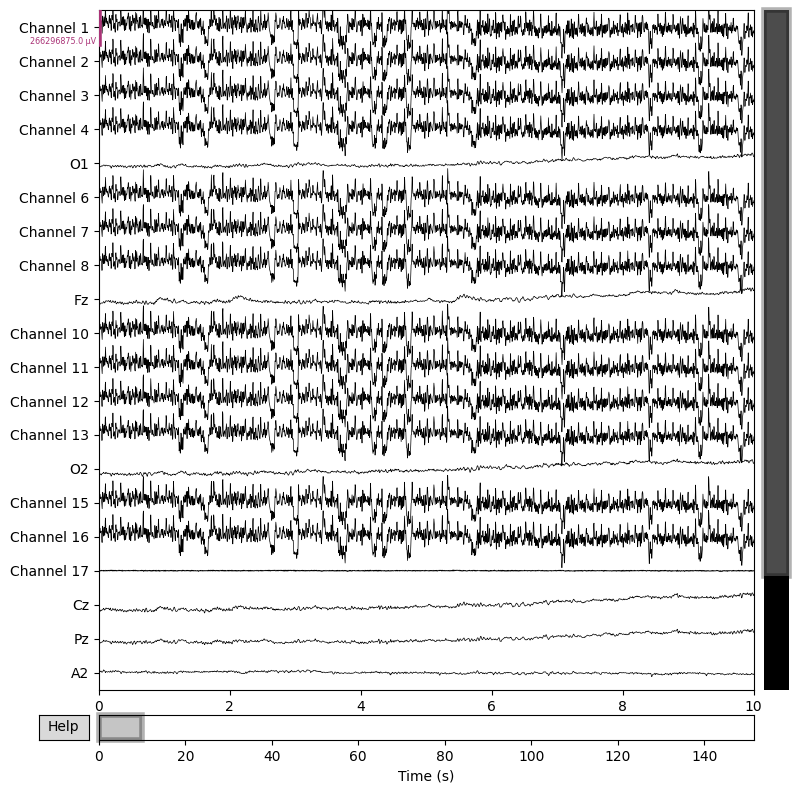

Using rejection criteria: None
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 257 original time points ...
5 bad epochs dropped


<ipython-input-28-4bd19782469e>:85: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(


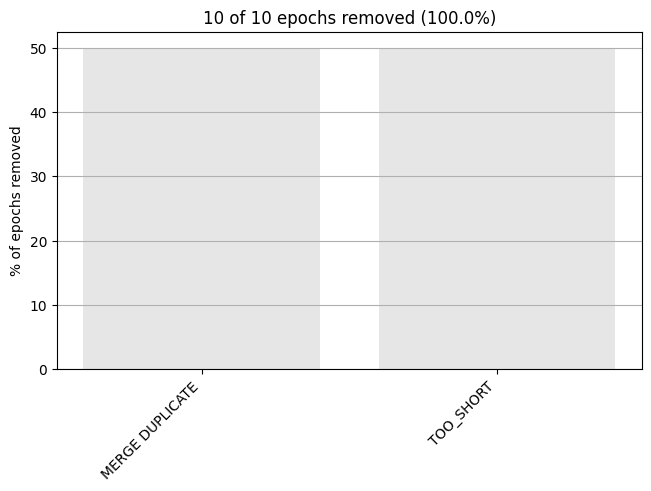

จำนวน epochs ที่สร้างขึ้น: 0
ช่องใน epochs: ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'O1', 'Channel 6', 'Channel 7', 'Channel 8', 'Fz', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'O2', 'Channel 15', 'Channel 16', 'Channel 17', 'Cz', 'Pz', 'A2', 'Channel 21', 'Channel 22', 'Channel 23', 'Channel 24']
(('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',), ('TOO_SHORT',), ('MERGE DUPLICATE',))


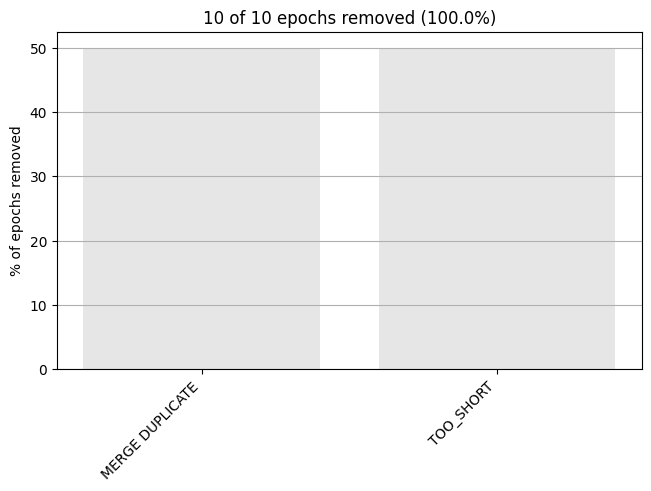

ไม่มี epochs สำหรับการ plot


In [28]:
# ติดตั้งไลบรารีที่จำเป็น
#!pip install pyxdf
#!pip install mne

# นำเข้าไลบรารีที่จำเป็น
import numpy as np
import pandas as pd
import mne
import pyxdf
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive

# ขั้นตอนที่ 1: เชื่อมต่อ Google Drive
drive.mount('/content/drive')

# กำหนดเส้นทางไฟล์สำหรับไฟล์ XDF
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg2.xdf'  # ปรับเส้นทางไฟล์ตามที่จำเป็น

# ฟังก์ชันสำหรับโหลดข้อมูลจากไฟล์ XDF (ไม่มีการเปลี่ยนแปลง)
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    # ค้นหาสตรีม EEG และ Marker
    for stream in streams:
        if stream['info']['name'][0].lower() == 'eeg' and stream['info']['type'][0].lower() == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0].lower() == 'markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบสตรีมชื่อ 'eeg' ในไฟล์ {filepath}")

    # สกัดข้อมูล EEG
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # แปลงเป็น DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    # สกัด markers ถ้ามี
    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

def create_epochs(data, markers, sampling_rate, epoch_duration=1):
    events = []

    print(f"Markers: {markers}")

    for timestamp, marker in markers:
        try:
            event_value = int(marker[0])
            events.append([int(timestamp * sampling_rate), 0, event_value])
        except ValueError as e:
            print(f"Error converting marker {marker} at timestamp {timestamp}: {e}")

    events = np.array(events)

    if len(events) == 0:
        raise ValueError("No valid events were created from markers.")

    info = mne.create_info(ch_names=data.columns.tolist(), sfreq=sampling_rate, ch_types='eeg')
    raw = mne.io.RawArray(data.T, info)

    # Uncomment and adjust to mark bad channels if necessary
    # raw.info['bads'] += ['Channel X']

    raw.plot(scalings='auto', title='Raw EEG Data')

    # Adjust the rejection criteria for testing
    reject_criteria = None  # ปิดการใช้งาน rejection criteri
    print("Using rejection criteria:", reject_criteria)

    try:
        epochs = mne.Epochs(
    raw,
    events,
    event_id=None,
    tmin=-0.5,  # Start 0.5 seconds before the event
    tmax=0.5,   # End 0.5 seconds after the event
    baseline=None,
    detrend=None,
    reject=reject_criteria,
    preload=True,
    event_repeated='merge'
)

        if len(epochs) == 0:
            print("Warning: No epochs remaining after rejection.")

        epochs.plot_drop_log()

    except ValueError as e:
        print(f"Error creating epochs: {e}")
        return None

    return epochs

# ฟังก์ชันสำหรับการ plot สเปกตรัมพลังงาน (ด้วยวิธีเพิ่มเติมสำหรับการคำนวณ psd)
def plot_power_spectrum(epochs, channel_names, title='Power Spectrum'):
    # ใช้วิธี Welch สำหรับการคำนวณความหนาแน่นของพลังงานสเปกตรัม
    psds, freqs = epochs.compute_psd(method='welch', fmin=0.1, fmax=40).get_data(return_freqs=True)

    # plot สเปกตรัมพลังงานสำหรับแต่ละช่อง
    plt.figure(figsize=(10, 6))
    for i, chan in enumerate(channel_names):
        plt.plot(freqs, psds[i], label=chan)

    plt.title(title)
    plt.xlabel('ความถี่ (Hz)')
    plt.ylabel('ความหนาแน่นของพลังงานสเปกตรัม (dB)')
    plt.legend()
    plt.show()

# โหลดข้อมูลจากไฟล์ XDF
df, sampling_rate, markers = load_data(file_path)

# สร้าง epochs โดยมีการจัดการข้อผิดพลาดที่ปรับแก้
epochs = create_epochs(df, markers, sampling_rate, epoch_duration=0.5)

if epochs is None:
    print("ข้อผิดพลาด: การสร้าง epochs ล้มเหลว")
else:
    print(f"จำนวน epochs ที่สร้างขึ้น: {len(epochs)}")
    print(f"ช่องใน epochs: {epochs.ch_names}")

    # ตรวจสอบ log การลบ
    if epochs is not None:
        print(epochs.drop_log)
        epochs.plot_drop_log()

if epochs is None or len(epochs) == 0:
    print("ไม่มี epochs สำหรับการ plot")
else:
    print(f"จำนวน epochs ที่มี: {len(epochs)}")
    print(f"ชื่อช่อง: {epochs.ch_names}")

    # plot สเปกตรัมพลังงาน
    plot_power_spectrum(epochs, epochs.ch_names, 'EEG Power Spectrum')